In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import json
from scipy.stats import zscore

def distance_to_line(line, pts, l0=None, p0=None):
    """
    line defined between l0 and line 
    points defined between p0 and pts
    """
    # line origin other than (0,0,0,..)
    if l0 is not None:
        line = line-l0
    # points origin other than (0,0,0,..)
    if p0 is not None:
        pts = pts-p0
    dp = np.dot(pts,line)
    pp = dp/np.linalg.norm(line)
    pn = np.linalg.norm(pts, axis=1)
    return np.sqrt(pn**2 - pp**2)

In [2]:
#open file with SH coefficients
folder = 'D:/Data/GalvanotaxisiSIM/Processed_Data/Data_and_Figs/' 
shcoeffs = pd.read_csv(folder+'Shape_Metrics_with_Digitized_PCs.csv', index_col=0)

In [3]:
######### Perform PCA ################


#specify number of PCs and number of bins

nbins = 5
bins = list(range(1,nbins+1))
lmax = 10

#get only shcoeffs
coeff_df = shcoeffs[[x for x in shcoeffs.columns.to_list() if 'shcoeffs' in x]]
npcs = coeff_df.shape[1]


# Fit and transform the data
pca = PCA(n_components=npcs)
pca = pca.fit(coeff_df)
matrix_of_features_transform = pca.transform(coeff_df)


# Dataframe of transformed variable
pc_names = [f"PC{c}" for c in range(1, 1 + npcs)]
df_trans = pd.DataFrame(data=matrix_of_features_transform, columns=pc_names, index = coeff_df.index)


# Adjust the sign of PCs so that larger cells are represent by positive values
#need actual volume data to do this so needs to be combined with shape metrics
df_trans['Cell_Volume'] = shcoeffs.Cell_Volume
for pcid, pc_name in enumerate(pc_names):
    pearson = np.corrcoef(df_trans.Cell_Volume.values, df_trans[pc_name].values)
    if pearson[0, 1] < 0:
        df_trans[pc_name] *= -1
        pca.components_[pcid] *= -1
        
df_trans = df_trans.drop(columns = 'Cell_Volume')

In [100]:
###################### find cells at specific PC percentiles that are the closest to average in all other PCs ##########
#number of cells per percentile
cpp = 3
#percentiles to look at
percentiles = [1, 16, 50, 84, 99]
#range around percentile to look for cells
per_win = 1
#make dict to fill
cell_file = {}

for p in pc_names[0:3]:
    cell_file[p] = {}
    for per in percentiles:
        #get PC value associated with given percentile
        plow = np.percentile(df_trans[p].values,per-per_win)
        phigh = np.percentile(df_trans[p].values,per+per_win)
        #get cells near that percentile for that particular PC
        cells_in = df_trans[df_trans[p].between(plow, phigh, inclusive='both')].index
        distances = distance_to_line(line = pca.components_[pc_names.index(p)],
                        pts = df_trans.loc[cells_in].to_numpy())
        cell_file[p][per] = pd.Series(distances, index = cells_in).sort_values().iloc[:cpp].index.to_list()

#write dict to file      
with open(folder+'VIEWs_index.txt', 'w') as convert_file:
     convert_file.write(json.dumps(cell_file))

In [25]:
############## find linear discriminate axis for a particular factor ##################

#how many PCs to use
ldpcs = 10
#use first 10 PCs
ldd = df_trans.iloc[:,:ldpcs]
lda = LinearDiscriminantAnalysis()
lda = lda.fit(ldd, shcoeffs.Migration_Mode)
lddt = lda.transform(ldd)


(array([ 1.,  4.,  9., 12., 16., 15., 23., 14., 16.,  6.]),
 array([-2.46656094, -1.99707597, -1.52759101, -1.05810604, -0.58862107,
        -0.1191361 ,  0.35034887,  0.81983383,  1.2893188 ,  1.75880377,
         2.22828874]),
 <a list of 10 Patch objects>)

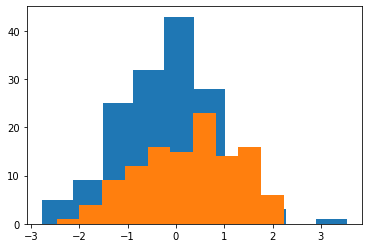

In [26]:
############ confirming separation of categories along LDA ###############
import matplotlib.pyplot as plt
lda_data = pd.Series([x[0] for x in lddt], index = shcoeffs.Migration_Mode)
plt.hist(lda_data[lda_data.index == 'Galvanotaxis'])
plt.hist(lda_data[lda_data.index == 'Galvanotaxis_Random'])

In [31]:
###################### find cells at specific LDA percentiles that are the closest to average in all other PCs ##########

#construct dataframe using LD data
lda_data = pd.Series([x[0] for x in lddt], index = shcoeffs.index)

#number of cells per percentile
cpp = 3
#percentiles to look at
percentiles = [1, 16, 50, 84, 99]
#range around percentile to look for cells
per_win = 1
#make dict to fill
cell_file = {}

for per in percentiles:
    #get PC value associated with given percentile
    plow = np.percentile(lda_data.values,per-per_win)
    phigh = np.percentile(lda_data.values,per+per_win)
    #get cells near that percentile for that particular PC
    cells_in = lda_data[lda_data.between(plow, phigh, inclusive='both')].index
    distances = distance_to_line(line = lda.coef_[0],
                    pts = df_trans.loc[cells_in].iloc[:,:ldpcs].to_numpy())
    cell_file[per] = pd.Series(distances, index = cells_in).sort_values().iloc[:cpp].index.to_list()

#write dict to file      
with open(folder+'LDA_VIEWs_index.txt', 'w') as convert_file:
     convert_file.write(json.dumps(cell_file))


{1: ['20230131_488actinGFP_646CAAXHalotag_2mA5_cell_5_frame_8',
  '20230126_488actinGFP_646CAAXHalotag_2mA1_cell_1_frame_9',
  '20230126_488actinGFP_646CAAXHalotag_2mA_30C2_cell_7_frame_5'],
 16: ['20230201_488actinGFP_646CAAXHalotag_2mA4_cell_3_frame_13',
  '20230131_488actinGFP_646CAAXHalotag_2mA3_cell_0_frame_13',
  '20230126_488actinGFP_646CAAXHalotag_2mA_30C1_cell_26_frame_12'],
 50: ['20230126_488actinGFP_646CAAXHalotag_2mA4_cell_9_frame_9',
  '20230131_488actinGFP_646CAAXHalotag_2mA5_cell_5_frame_7',
  '20230201_488actinGFP_646CAAXHalotag_2mA1_cell_1_frame_4'],
 84: ['20230126_488actinGFP_646CAAXHalotag_2mA4_cell_9_frame_5',
  '20230126_488actinGFP_646CAAXHalotag_2mA5_cell_0_frame_0',
  '20230201_488actinGFP_646CAAXHalotag_2mA3_cell_7_frame_15'],
 99: ['20230126_488actinGFP_646CAAXHalotag_2mA_30C3_cell_3_frame_2',
  '20230126_488actinGFP_646CAAXHalotag_2mA_30C1_cell_9_frame_13',
  '20230201_488actinGFP_646CAAXHalotag_2mA4_cell_8_frame_15']}